In [1]:
import numpy as np
import tqdm
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [4]:
data = pd.read_csv('/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv', encoding="utf-8", encoding_errors="replace")
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
data.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [6]:
def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

In [7]:
def preprocess_data(df_data):
    """
    Preprocesses a DataFrame by cleaning and preparing text data in the 'Review' column.

    Steps:
    1. Create a copy of the DataFrame.
    2. Remove duplicate rows.
    3. Drop rows with missing values.
    4. Strip whitespace from the 'Review' column.
    5. Remove non-alphanumeric characters except whitespace.
    6. Replace newline characters with a space.
    7. Convert text to lowercase.
    8. Remove URLs.
    9. Strip extra spaces.
    10. Remove rows with empty 'Review' after cleaning.
    11. Reset index.

    Args:
        df_data (pd.DataFrame): The input DataFrame containing a 'Review' column.

    Returns:
        pd.DataFrame: A cleaned DataFrame.
    """
    df_copy = df_data.copy()
    df_copy.drop_duplicates(inplace=True)
    df_copy.dropna(inplace=True)
    df_copy['Review'] = df_copy['Review'].str.strip()
    df_copy['Review'] = df_copy['Review'].str.replace(r'[^\w\s]', '', regex=True)
    df_copy['Review'] = df_copy['Review'].str.replace(r'\n', ' ', regex=True)
    df_copy['Review'] = df_copy['Review'].str.lower()
    df_copy['Review'] = df_copy['Review'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
    df_copy['Review'] = df_copy['Review'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))
    df_copy['Review'] = df_copy['Review'].apply(lambda x: ' '.join(x.split()))
    df_copy = df_copy[df_copy['Review'].str.len() > 0]
    df_copy.reset_index(drop=True, inplace=True)
    df_copy['sentiment'] = df_copy['Rating'].apply(label_sentiment)
    return df_copy

In [8]:
cleaned_data = preprocess_data(data)
cleaned_data.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [9]:
cleaned_data.head()

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,negative
2,nice rooms not experience hotel monaco seattle...,3,neutral
3,unique great stay wonderful time hotel monaco ...,5,positive
4,great stay great stay went seahawk game awesom...,5,positive


In [10]:
def data_discription(df):
    """
    Visualizes the distribution of ratings in a DataFrame.

    This function calculates the percentage distribution of the 'Rating' column
    and creates a bar plot to show the frequency of each rating as a percentage.

    Args:
        df (pd.DataFrame): The input DataFrame containing a 'Rating' column.

    Returns:
        None: Displays a bar plot of the ratings distribution.
    """
    # Step 1: Calculate the percentage distribution of ratings
    ratings_count = df['Rating'].value_counts(normalize=True) * 100

    # Step 2: Create a bar plot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=ratings_count.index, y=ratings_count.values, palette="viridis")

    # Step 3: Add percentage labels to the bars
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.1f}%',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=12,
            color='black', xytext=(0, 5),
            textcoords='offset points'
        )

    # Step 4: Label the axes and title
    plt.xlabel("Rating", fontsize=12)
    plt.ylabel("Percentage", fontsize=12)
    plt.title("Distribution of Ratings", fontsize=14)

    # Step 5: Display the plot
    plt.show()

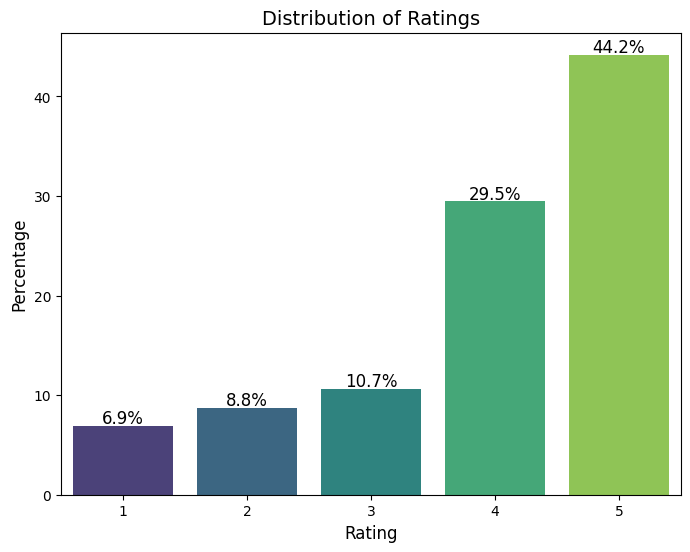

In [11]:
data_discription(cleaned_data)

In [12]:
def tokenize_text(df):
    """
    Tokenizes the text in the 'Review' column.

    Args:
        df (pd.DataFrame): DataFrame containing a 'Review' column.

    Returns:
        pd.DataFrame: DataFrame with a new 'tokens' column containing tokenized words.
    """
    df['tokens'] = df['Review'].apply(word_tokenize)
    return df

In [13]:
cleaned_data = tokenize_text(cleaned_data)
cleaned_data.head()

,Review,Rating,sentiment,tokens
0,nice hotel expensive parking got good deal sta...,4,positive,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,negative,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms not experience hotel monaco seattle...,3,neutral,"[nice, rooms, not, experience, hotel, monaco, ..."
3,unique great stay wonderful time hotel monaco ...,5,positive,"[unique, great, stay, wonderful, time, hotel, ..."
4,great stay great stay went seahawk game awesom...,5,positive,"[great, stay, great, stay, went, seahawk, game..."


In [14]:
def remove_stopwords(df):
    """
    Removes stopwords from the tokenized text.

    Args:
        df (pd.DataFrame): DataFrame with a 'tokens' column.

    Returns:
        pd.DataFrame: DataFrame with a new 'tokens_no_stop' column containing tokens without stopwords.
    """
    stop_words = set(stopwords.words('english'))
    df['tokens_no_stop'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
    return df

In [15]:
def lemmatize_text(df):
    """
    Lemmatizes the tokens in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with a 'tokens_no_stop' column.

    Returns:
        pd.DataFrame: DataFrame with a new 'lemmatized' column containing lemmatized tokens.
    """
    lemmatizer = WordNetLemmatizer()
    df['lemmatized'] = df['tokens_no_stop'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return df

In [16]:
def join_tokens(df):
    """
    Joins the lemmatized tokens back into a single string.

    Args:
        df (pd.DataFrame): DataFrame with a 'lemmatized' column.

    Returns:
        pd.DataFrame: DataFrame with a new 'processed_text' column containing the joined text.
    """
    df['processed_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))
    return df

In [17]:
cleaned_data = remove_stopwords(cleaned_data)
cleaned_data = lemmatize_text(cleaned_data)
cleaned_data = join_tokens(cleaned_data)
cleaned_data.head()

,Review,Rating,sentiment,tokens,tokens_no_stop,lemmatized,processed_text
0,nice hotel expensive parking got good deal sta...,4,positive,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...",nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,negative,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...",ok nothing special charge diamond member hilto...
2,nice rooms not experience hotel monaco seattle...,3,neutral,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, rooms, experience, hotel, monaco, seatt...","[nice, room, experience, hotel, monaco, seattl...",nice room experience hotel monaco seattle good...
3,unique great stay wonderful time hotel monaco ...,5,positive,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...",unique great stay wonderful time hotel monaco ...
4,great stay great stay went seahawk game awesom...,5,positive,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...",great stay great stay went seahawk game awesom...


In [18]:
def create_tfidf(df, max_features=100):
    """
    Converts the processed text data into a TF-IDF matrix.

    This function performs TF-IDF (Term Frequency-Inverse Document Frequency) vectorization
    on the 'processed_text' column of the DataFrame to transform the text into numerical features.

    Args:
        df (pd.DataFrame): DataFrame containing a 'processed_text' column with preprocessed text data.
        max_features (int, optional): The maximum number of features to consider for the TF-IDF matrix.
                                      Defaults to 5000.

    Returns:
        tuple: A tuple containing:
            - tfidf_matrix (scipy.sparse.csr.csr_matrix): The TF-IDF feature matrix.
            - tfidf (TfidfVectorizer): The fitted TfidfVectorizer object for possible reuse.
    """
    # Initialize the TfidfVectorizer with the specified max_features
    tfidf = TfidfVectorizer(max_features=max_features)

    # Fit and transform the 'processed_text' column to create the TF-IDF matrix
    tfidf_matrix = tfidf.fit_transform(df['processed_text']).toarray()

    return tfidf_matrix, tfidf

In [19]:
tfidf_matrix, tfidf_vectorizer = create_tfidf(cleaned_data)
cleaned_data.head()

,Review,Rating,sentiment,tokens,tokens_no_stop,lemmatized,processed_text
0,nice hotel expensive parking got good deal sta...,4,positive,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...",nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,negative,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...",ok nothing special charge diamond member hilto...
2,nice rooms not experience hotel monaco seattle...,3,neutral,"[nice, rooms, not, experience, hotel, monaco, ...","[nice, rooms, experience, hotel, monaco, seatt...","[nice, room, experience, hotel, monaco, seattl...",nice room experience hotel monaco seattle good...
3,unique great stay wonderful time hotel monaco ...,5,positive,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...",unique great stay wonderful time hotel monaco ...
4,great stay great stay went seahawk game awesom...,5,positive,"[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...","[great, stay, great, stay, went, seahawk, game...",great stay great stay went seahawk game awesom...


In [20]:
tfidf_matrix

array([[0.        , 0.        , 0.18900044, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.11575023, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03203368, 0.04094515, ..., 0.03721662, 0.        ,
        0.12326252],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [21]:
def create_balanced_dataset(df, n_samples=20491):
    """
    Create a balanced dataset with specified number of samples
    """
    # Convert sentiment to numeric
    sentiment_map = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }
    df['label_sentiment'] = df['sentiment'].map(sentiment_map)

    # Calculate samples per class
    samples_per_class = n_samples // 3

    # Get balanced data for each class
    balanced_dfs = []
    for label in range(3):
        class_df = df[df['label_sentiment'] == label]
        if len(class_df) > samples_per_class:
            balanced_dfs.append(class_df.sample(n=samples_per_class,
random_state=42))
        else:
            # If we don't have enough samples, oversample
            balanced_dfs.append(class_df.sample(n=samples_per_class,
replace=True, random_state=42))

    # Combine balanced datasets
    balanced_df = pd.concat(balanced_dfs)

    # Shuffle the final dataset
    return balanced_df.sample(frac=1, random_state=42)

In [22]:
create_balanced_dataset(cleaned_data, n_samples=1000).head()

,Review,Rating,sentiment,tokens,tokens_no_stop,lemmatized,processed_text,label_sentiment
1351,great location spent nights beachcomber hotel ...,3,neutral,"[great, location, spent, nights, beachcomber, ...","[great, location, spent, nights, beachcomber, ...","[great, location, spent, night, beachcomber, h...",great location spent night beachcomber hotel e...,1
12846,geat staff rooms clean efficient delightful st...,5,positive,"[geat, staff, rooms, clean, efficient, delight...","[geat, staff, rooms, clean, efficient, delight...","[geat, staff, room, clean, efficient, delightf...",geat staff room clean efficient delightful sta...,2
755,just got day stay definitely not recommned pla...,1,negative,"[just, got, day, stay, definitely, not, recomm...","[got, day, stay, definitely, recommned, place,...","[got, day, stay, definitely, recommned, place,...",got day stay definitely recommned place room d...,0
8421,facilities gone againbeautiful location lot li...,2,negative,"[facilities, gone, againbeautiful, location, l...","[facilities, gone, againbeautiful, location, l...","[facility, gone, againbeautiful, location, lot...",facility gone againbeautiful location lot litt...,0
19950,thoroughly recommend hotel stayed hotel recent...,5,positive,"[thoroughly, recommend, hotel, stayed, hotel, ...","[thoroughly, recommend, hotel, stayed, hotel, ...","[thoroughly, recommend, hotel, stayed, hotel, ...",thoroughly recommend hotel stayed hotel recent...,2


In [23]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Debugging print to check the contents of texts and labels
        print(f"Sample text: {self.texts[0]}")  # Debug print to inspect the first text
        print(f"Sample label: {self.labels[0]}")  # Debug print to inspect the first label

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        # Tokenization of text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [24]:
def train_sentiment_model(df, model_pretrained="Roberta", test_size=0.2, num_epochs=5, batch_size=16, learning_rate=2e-5):
    # Create a balanced dataset
    print("Creating balanced dataset...")
    balanced_df = create_balanced_dataset(df, n_samples=20491)
    print(f"Columns after balancing: {balanced_df.columns}")  # Debugging line
    print(f"Class distribution:\n{balanced_df['label_sentiment'].value_counts()}")

    # Split the data
    train_df, test_df = train_test_split(
        balanced_df, test_size=test_size, random_state=42, stratify=balanced_df['label_sentiment']
    )

    # Ensure 'processed_text' exists in both splits
    print(f"Columns in train_df: {train_df.columns}")  # Debugging line
    print(f"Columns in test_df: {test_df.columns}")    # Debugging line

    # Get texts and labels
    try:
        train_texts, train_labels = train_df['processed_text'].tolist(), train_df['label_sentiment'].tolist()
        test_texts, test_labels = test_df['processed_text'].tolist(), test_df['label_sentiment'].tolist()
    except KeyError as e:
        print(f"KeyError: {e}")
        return

    # Debugging: Print first few samples from train_texts and train_labels
    print(f"Sample of train texts: {train_texts[:3]}")
    print(f"Sample of train labels: {train_labels[:3]}")

    # Initialize tokenizer
    if model_pretrained == "Roberta":
        print("Initializing RoBERTa tokenizer...")
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    elif model_pretrained == "Bert":
        print("Initializing BERT tokenizer...")
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
        

    # Create datasets
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    if model_pretrained == "Roberta":
        print("Initializing RoBERTa model...")
        model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
    elif model_pretrained == "Bert": 
        print("Initializing BERT model...")
        model =  BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3) 
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Training loop
    print(f"Training on {device}")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        pbar = tqdm.tqdm(train_loader, unit="batches")

        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        test_preds, test_true = [], []
        valid_loss = 0

        print("\nEvaluating...")
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                valid_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1)

                test_preds.extend(preds.cpu().numpy())
                test_true.extend(labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(test_true, test_preds)
        print(f'Average training loss: {train_loss / len(train_loader):.4f}')
        print(f"Averge validation loss: {valid_loss / len(test_loader):.4f}")
        print(f'Test Accuracy: {accuracy:.4f}')

        # Detailed classification report
        print('\nClassification Report:')
        print(classification_report(test_true, test_preds, target_names=['negative', 'neutral', 'positive']))

    # Save the model
    print("\nSaving model...")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'tokenizer': tokenizer
    }, 'Bert_sentiment_model_balanced.pth')

    return model, tokenizer

In [25]:
def predict_sentiment(text, model, tokenizer, device):
    # Set model to evaluation mode
    model.eval()

    # Tokenize and encode the input text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Move tensors to the specified device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Make predictions without computing gradients
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).cpu().item()

        # Calculate probabilities using softmax
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]

    # Define sentiment mapping
    sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}

    # Return the predicted sentiment and confidence score
    return sentiment_map[pred], probs[pred]


In [26]:
# Assuming df is your input dataframe
print("Starting training process...")

# Train the sentiment model
model, tokenizer = train_sentiment_model(cleaned_data, model_pretrained="Bert")

# Example text for prediction
example_text = "The geosolutions technology will leverage benefon GPS solutions"

# Determine the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Predict sentiment for the example text
sentiment, confidence = predict_sentiment(example_text, model, tokenizer, device)

# Output the prediction result
print(f"\nExample prediction for: '{example_text}'")
print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.2f})")

Starting training process...
Creating balanced dataset...
Columns after balancing: Index(['Review', 'Rating', 'sentiment', 'tokens', 'tokens_no_stop',
       'lemmatized', 'processed_text', 'label_sentiment'],
      dtype='object')
Class distribution:
label_sentiment
2    6830
1    6830
0    6830
Name: count, dtype: int64
Columns in train_df: Index(['Review', 'Rating', 'sentiment', 'tokens', 'tokens_no_stop',
       'lemmatized', 'processed_text', 'label_sentiment'],
      dtype='object')
Columns in test_df: Index(['Review', 'Rating', 'sentiment', 'tokens', 'tokens_no_stop',
       'lemmatized', 'processed_text', 'label_sentiment'],
      dtype='object')
Sample of train texts: ['beautiful hotel returned wonderful stay lennox room beautiful large hotel staff extremely accomodating room service breakfast delicious great location close pru tower trinity church boston public library public transportation need car boston subway stop block away hop hop trolley purchased hotel great restauran

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sample text: beautiful hotel returned wonderful stay lennox room beautiful large hotel staff extremely accomodating room service breakfast delicious great location close pru tower trinity church boston public library public transportation need car boston subway stop block away hop hop trolley purchased hotel great restaurant atlantic fish block away
Sample label: 2
Sample text: nice place stayed night bellevue hotel septemberoctober hotel room clean tiny nt bothered room fulllenght mirror wich think useful bed confythe staff friendly helpful restaurant surprised really nice food room stayed nt noisy relax sleep walking day long amsterdam lovely city hotel great location central minute walk train stationbellevue hotel great value money recommend
Sample label: 2
Initializing BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training on cuda

Epoch 1/5


100%|██████████| 1025/1025 [06:18<00:00,  2.71batches/s]



Evaluating...
Average training loss: 0.5756
Averge validation loss: 0.4454
Test Accuracy: 0.8265

Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.85      0.88      1366
     neutral       0.80      0.70      0.74      1366
    positive       0.78      0.94      0.85      1366

    accuracy                           0.83      4098
   macro avg       0.83      0.83      0.82      4098
weighted avg       0.83      0.83      0.82      4098


Epoch 2/5


100%|██████████| 1025/1025 [06:26<00:00,  2.65batches/s]



Evaluating...
Average training loss: 0.2941
Averge validation loss: 0.3093
Test Accuracy: 0.8973

Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.90      0.93      1366
     neutral       0.82      0.92      0.87      1366
    positive       0.93      0.87      0.90      1366

    accuracy                           0.90      4098
   macro avg       0.90      0.90      0.90      4098
weighted avg       0.90      0.90      0.90      4098


Epoch 3/5


100%|██████████| 1025/1025 [06:26<00:00,  2.65batches/s]



Evaluating...
Average training loss: 0.1482
Averge validation loss: 0.2944
Test Accuracy: 0.9187

Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.94      0.95      1366
     neutral       0.86      0.94      0.90      1366
    positive       0.94      0.88      0.91      1366

    accuracy                           0.92      4098
   macro avg       0.92      0.92      0.92      4098
weighted avg       0.92      0.92      0.92      4098


Epoch 4/5


100%|██████████| 1025/1025 [06:26<00:00,  2.65batches/s]



Evaluating...
Average training loss: 0.0873
Averge validation loss: 0.2870
Test Accuracy: 0.9287

Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.96      0.95      1366
     neutral       0.90      0.92      0.91      1366
    positive       0.94      0.90      0.92      1366

    accuracy                           0.93      4098
   macro avg       0.93      0.93      0.93      4098
weighted avg       0.93      0.93      0.93      4098


Epoch 5/5


100%|██████████| 1025/1025 [06:26<00:00,  2.65batches/s]



Evaluating...
Average training loss: 0.0523
Averge validation loss: 0.3257
Test Accuracy: 0.9285

Classification Report:
              precision    recall  f1-score   support

    negative       0.96      0.95      0.95      1366
     neutral       0.88      0.95      0.91      1366
    positive       0.96      0.89      0.92      1366

    accuracy                           0.93      4098
   macro avg       0.93      0.93      0.93      4098
weighted avg       0.93      0.93      0.93      4098


Saving model...

Example prediction for: 'The geosolutions technology will leverage benefon GPS solutions'
Predicted sentiment: positive (confidence: 0.92)


In [27]:
# Example text for prediction
example_text = "the hospitality in Morocco has to be noticed and considered"

# Determine the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Predict sentiment for the example text
sentiment, confidence = predict_sentiment(example_text, model, tokenizer, device)

# Output the prediction result
print(f"\nExample prediction for: '{example_text}'")
print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.2f})")


Example prediction for: 'the hospitality in Morocco has to be noticed and considered'
Predicted sentiment: positive (confidence: 0.98)
